In [3]:
import pandas as pd
import torch
import torch.nn as nn
import tensorflow as tf

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.models as models
import matplotlib.pyplot as plt
import pathlib

import albumentations as A

#from tensorflow.keras.applications import MobileNetV2


In [4]:
!unzip public_tests.zip

Streaming output truncated to the last 5000 lines.
  inflating: 00_test_img_input/test/images/0672.jpg  
  inflating: 00_test_img_input/test/images/2085.jpg  
  inflating: 00_test_img_input/test/images/0106.jpg  
  inflating: 00_test_img_input/test/images/1056.jpg  
  inflating: 00_test_img_input/test/images/1159.jpg  
  inflating: 00_test_img_input/test/images/0256.jpg  
  inflating: 00_test_img_input/test/images/2269.jpg  
  inflating: 00_test_img_input/test/images/0664.jpg  
  inflating: 00_test_img_input/test/images/1981.jpg  
  inflating: 00_test_img_input/test/images/0929.jpg  
  inflating: 00_test_img_input/test/images/1888.jpg  
  inflating: 00_test_img_input/test/images/0957.jpg  
  inflating: 00_test_img_input/test/images/0389.jpg  
  inflating: 00_test_img_input/test/images/0323.jpg  
  inflating: 00_test_img_input/test/images/0717.jpg  
  inflating: 00_test_img_input/test/images/0186.jpg  
  inflating: 00_test_img_input/test/images/0468.jpg  
  inflating: 00_test_img_input/

In [24]:
import torchvision.transforms as transforms
import os

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 50)


# mobilenet = tf.keras.applications.MobileNetV2()
# class MNIST_dataset(Dataset):
#   def __init__(self, path_to_data):
#     super().__init__()
#     self.path_to_data = pathlib.Path(path_to_data)
#     self.paths = list(self.path_to_data.rglob('*.png'))

#   def __len__(self):
#     return len(self.paths)

#   def __getitem__(self, index):
#     return read_image(self.paths[index].as_posix()).squeeze(dim=0)/255, torch.tensor(int(self.paths[index].as_posix().split('/')[-2]))

class CustomDataset(Dataset):
    def __init__(self, root_dir, images_per_class=50, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_per_class = images_per_class
        self.images = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = idx // self.images_per_class
        return image, label

# Example usage:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])


Is CUDA supported by this system? False
CUDA version: 12.1


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [13]:
train_data = CustomDataset('00_test_img_input/train/images', images_per_class=50, transform=data_transform)
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = CustomDataset('00_test_img_input/test/images', images_per_class=50, transform=data_transform)
valid_data_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [ ]:
# class MyModel(nn.Module):
#   def __init__(self, h_d):
#     super().__init__()
#     self.flat = nn.Flatten(1,-1)
#     self.fc1 = nn.Linear(28*28, h_d)
#     self.a = nn.ReLU()
#     self.fc2 = nn.Linear(h_d, 10)

#   def forward(self, x):
#     o = self.flat(x)
#     o = self.fc1(o)
#     o = self.a(o)
#     return self.fc2(o)

# model = MyModel(100)

In [14]:
from torch.optim import Adam

In [15]:
creterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
from tqdm import tqdm

In [19]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from PIL import Image

In [20]:
num_epochs = 15
best_accuracy = 0
early_stopping_counter = 0
early_stopping_limit = 5  # Adjust as needed

for epoch in range(num_epochs):
  model.train()
  for x, y in tqdm(train_data_loader):
    y_pred = model(x)
    loss = creterion(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  model.eval()
  val_predictions = []
  val_targets = []
  with torch.no_grad():
    for x, y in valid_data_loader:
      y_pred = model(x)
      val_predictions.extend(torch.argmax(y_pred, dim=1).tolist())
      val_targets.extend(y.tolist())

  accuracy = accuracy_score(val_targets, val_predictions)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    early_stopping_counter = 0
  else:
    early_stopping_counter += 1

  if early_stopping_counter == early_stopping_limit:
    print(f'Early stopping at epoch {epoch} due to lack of improvement in validation accuracy.')
    break

  print(f'Epoch {epoch}: Validation Accuracy: {accuracy}')

100%|██████████| 40/40 [05:11<00:00,  7.78s/it]


Epoch 0: Validation Accuracy: 0.6072


100%|██████████| 40/40 [04:54<00:00,  7.36s/it]


KeyboardInterrupt: 

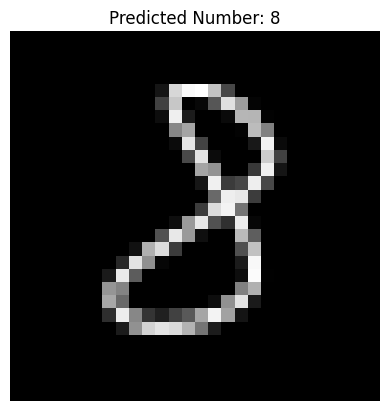

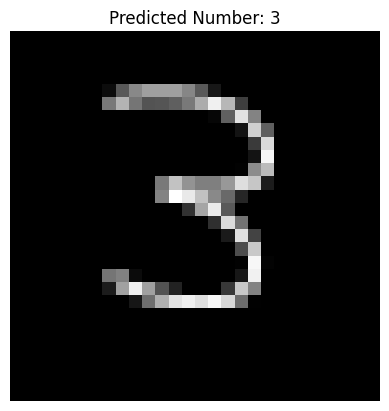

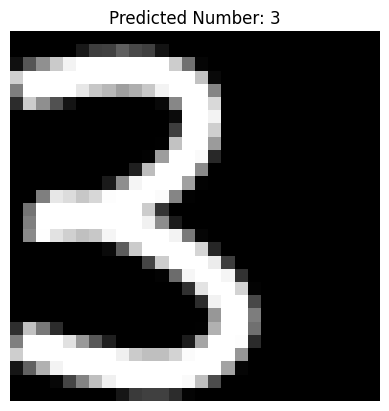

In [ ]:
from torchvision import transforms
from PIL import Image

# base transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])


def predict_number(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image)

    _, predicted = torch.max(output, 1)
    return predicted.item(), image

image_paths = ["Centered_8.png", "Centered_3.png", "Uncentered_3.png"]

for image_path in image_paths:
    predicted_number, image = predict_number(image_path)

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Predicted Number: {predicted_number}")
    plt.axis('off')
    plt.show()

torch.save(model.state_dict(), "model_weights.pth")